# Laboratorio 3: Reconocimiento de imágenes
## Aplicación en detección de Retinopatía Diabética
### Introducción
La retinopatía diabética es una enfermedad ocular que puede producirse en pacientes con diabetes. Se da debido a los altos niveles de azúcar en la sangre que causan daño a los vasos sanguíneos en la retina. Es general que no se presenten síntomas en las etapas tempranas. Los síntomas de la retinopatía diabética suelen afectar a ambos ojos. A medida que empeora la enfermedad, se presentan los siguientes síntomas:

* Un mayor número de moscas volantes
* Visión borrosa
* Visión que cambia de borrosa a clara
* Ver áreas en blanco u oscuras en el campo de visión
* Visión nocturna deficiente
* Notar que los colores se ven atenuados o apagados
* Pérdida la visión

#### Etapas y detección
La retinopatía se puede detectar de múltiples maneras, sin embargo existe un método a través del cual este padecimiento es detectado por inspección visual de los ojos del paciente. Los ojos, específicamente “un diferencial del ojo” se pueden observar nubosidades, que son hemorragias de los vasos sanguíneos.
![DR Stages](./assets/etapas.png)
![RD Detección](./assets/RetinopatiaDiabetica.jpg)

##### Tipos de retinopatía diabética
* Retinopatía diabética proliferativa: Esta es la etapa más avanzada de la enfermedad. Se produce cuando la retina comienza a desarrollar nuevos vasos sanguíneos. Esto se denomina neovascularización. Estos vasos nuevos frágiles a menudo sangran hacia el vítreo. La retinopatía diabética proliferativa es muy grave y puede hacerle perder tanto la visión central como la periférica.

* Retinopatía diabética no proliferativa: Esta es la etapa temprana de la enfermedad ocular diabética. La mayoría de las personas diabéticas padecen de este tipo de retinopatía. En esta etapa de la enfermedad, muchos vasos sanguíneos pequeños sufren pérdidas y hacen que la retina se hinche. Si  se tiene retinopatía diabética no proliferativa, la visión del paciente será borrosa

##### Problemas de detección
![Tensorflow Diagnosis](./assets/tensorflow.png)
La gráfica anterior muestra que incluso oftalmólogos pueden presentar inconsistencias a la hora de diagnosticar a un paciente como con, o sin, retinopatía diabética y el grado de la misma.

### Análisis del dataset

Las imágenes son de varias dimensiones, habiendo de 1050 x 1050 px, 3216 x 2136 px, entre otros, a color por lo que se recomienda modificar las imágenes a escala de grises, o bien una transformación que permita reducir la complejidad de la red neuronal, logrando reducir el uso de recursos computacionales. 

El dataset provisto contiene 3,662 observaciones para entrenar y 1,928 para testear. Las columnas que contiene el dataset es de código - de la cual no se presentará un análisis pues no brinda información esencial - y diagnosis, esta variable se distribuye de la siguiente manera:

![Original Train Diagnosis Histogram](./assets/diagnosisHist.png)
![Original Train Diagnosis Proportions](./assets/props.png)

El código para realizar las visualizaciones anteriores puede encontrarse en el archivo DataExploration.R

Se puede observar que la mayoría de imágenes, siendo casi un 50%, en el dataset de entrenamiento son diagnosticadas como “sin retinopatía diabética”, mientras que menos de un 5.3% y 8.1% son clasificadas como “severa” y “proliferativa”, respectivamente; esto puede repercutir en las respuestas que se obtengan con la red neuronal al introducir el test set, ya que podría sesgar la información y clasificar como “sin diagnosis”.

Algunas de las imágenes para cada diagnóstico son las siguientes:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os # Para importar las imagenes
from PIL import Image # Para visualizar las imagenes
import numpy as np

In [9]:
train_df = pd.read_csv('./csvs/train.csv')

# for i in range(611):
#     img = Image.open('./train_images/' + train_df['id_code'][i] + '.png').convert('LA')
#     new_image = img.resize((256, 256))
#     new_image.save('./transform_images/' + train_df['id_code'][i] + '.png')

#### 0 - No DR

In [10]:
no_dr = Image.open(train_df[train_df.diagnosis==0].iloc[0].path)
plt.imshow(np.asarray(no_dr))

AttributeError: 'Series' object has no attribute 'path'

#### 1 - Mild

In [ ]:
mild = Image.open(train_df[train_df.diagnosis==1].iloc[0].path)
plt.imshow(np.asarray(mild))

#### 2 - Moderate

In [ ]:
moderate = Image.open(train_df[train_df.diagnosis==2].iloc[0].path)
plt.imshow(np.asarray(moderate))

#### 3 - Severe

In [ ]:
sev = Image.open(train_df[train_df.diagnosis==3].iloc[0].path)
plt.imshow(np.asarray(sev))

#### 4 - Proliferative

In [ ]:
prol = Image.open(train_df[train_df.diagnosis==4].iloc[0].path)
plt.imshow(np.asarray(prol))

In [ ]:
train_df['path'] = train_df['id_code'].map(lambda x: os.path.join('./train_images/','{}.png'.format(x)))
train_df['path_gray'] = train_df['id_code'].map(lambda x: os.path.join('./transform_images/','{}.png'.format(x)))

In [ ]:
train_df = train_df[:610] #se usaran solo las primeras 611 fotos, por cuestiones de tiempo

In [ ]:
diagnosis_labs = pd.read_csv('./csvs/diagnosis.csv')

In [ ]:
train_df_labs = pd.merge(train_df, diagnosis_labs)
train_df_labs["diagnosis_n"].value_counts().plot(kind='bar')

Se puede observar que, ya que los diagnósticos estan distribuidos aleatoriamente en el csv original, escoger los primeros 611 no parece afectar a la distribución.

In [ ]:
# No lo vamos a usar todavia, pero importemoslo de una vez
submission = pd.read_csv('./csvs/test.csv')
submission

### Modificación de las imágenes

In [ ]:
# Ver dimensiones de imagen
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 
plt.imshow(np.asarray(im))

Se puede observar que las imagenes son bastante grandes, por lo cual será necesario para empezar, cambiar su tamaño.


Para empezar, creemos nuestros train y test set a partir de train_df. Escogeremos 65% y 35% al azar, respectivamente.

In [ ]:
# train, test = np.split(train_df.sample(frac=1), [int(.65*len(train_df))])

In [ ]:
# np.save('train_set.npy', train)
# np.save('test_set.npy', test)
train

In [ ]:
train=pd.DataFrame(np.load('train_set.npy', allow_pickle=True), columns=['id_code', 'diagnosis','path', 'path_gray'])
test=pd.DataFrame(np.load('test_set.npy', allow_pickle=True), columns=['id_code', 'diagnosis','path', 'path_gray'])

Ahora, se debe procurar compensar la sobre-representación de los casos sin retinopatía diabética en el dataset de train, ya que esto podría ser un bias que afectaría el cross validation y el test.

Para esto, se hará un oversampling.
Para referencia, esta es la distribución de nuestro nuevo train set, al escoger una muestra del 65% al azar:

In [ ]:
train_labs = pd.merge(train, diagnosis_labs)
train_labs["diagnosis_n"].value_counts().plot(kind='bar')

Se puede observar que la distribución de los diagnósticos se sigue manteniendo.

In [ ]:
max_size = train_labs['diagnosis_n'].value_counts().max()
max_size

In [ ]:
min_size = train_labs['diagnosis_n'].value_counts().min()
min_size

In [ ]:
# Realizamos el oversampling
# lst = [train_labs]
# for class_index, group in train_labs.groupby('diagnosis'):
#    lst.append(group.sample(max_size-len(group), replace=True))
# oversampled_train = pd.concat(lst)

In [ ]:
#np.save('oversampled_train.npy',oversampled_train)

In [26]:
oversampled_train=pd.DataFrame(np.load('oversampled_train.npy', allow_pickle=True), columns=['id_code',
                                                                                             'diagnosis',
                                                                                             'path',
                                                                                             'path_gray',
                                                                                             'diagnosis_n'])

<AxesSubplot:>

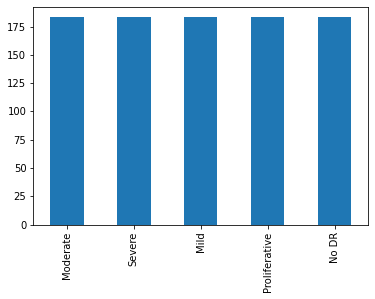

In [27]:
oversampled_train["diagnosis_n"].value_counts().plot(kind='bar')

In [ ]:
# no_dr = np.random.choice(train_labs[train_labs.diagnosis==0].index, min_size, replace=False)
# mild = np.random.choice(train_labs[train_labs.diagnosis==1].index, min_size, replace=False)
# moderate = np.random.choice(train_labs[train_labs.diagnosis==2].index, min_size, replace=False)
# severe = np.random.choice(train_labs[train_labs.diagnosis==3].index, min_size, replace=False)
# proliferative = np.random.choice(train_labs[train_labs.diagnosis==4].index, min_size, replace=False)

In [11]:
# undersample_indexes = np.concatenate([no_dr,mild,moderate,severe,proliferative])

<AxesSubplot:>

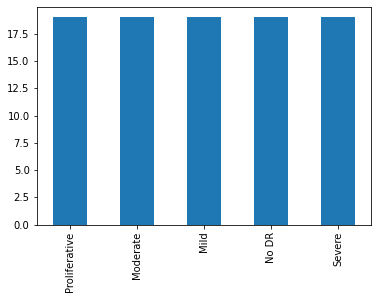

In [12]:
# undersampled_train = train_labs.loc[undersample_indexes]
# np.save('undersampled_train.npy',undersampled_train)
undersampled_train=pd.DataFrame(np.load('undersampled_train.npy', allow_pickle=True), columns=['id_code',
                                                                                             'diagnosis',
                                                                                             'path',
                                                                                             'path_gray',
                                                                                             'diagnosis_n'])
undersampled_train["diagnosis_n"].value_counts().plot(kind='bar')

### Transformaciones y Redes Neuronales
Se realizarán 2 modelos, uno con el dataset undersampled y el otro oversampled. Para empezar, cargaremos las librerías a utilizar y los datos del test.

In [62]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

In [65]:
test_images = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img(test["path_gray"][i], target_size=(256,256, 1), color_mode="grayscale")
    img = image.img_to_array(img)
    img = img/255
    test_images.append(img)
X_test = np.array(test_images)

y_test = test['diagnosis'].values
y_test = to_categorical(y_test)

100%|██████████| 214/214 [00:00<00:00, 361.84it/s]


#### Undersampled

In [64]:
undersampled_train

,id_code,diagnosis,path,path_gray,diagnosis_n
0,0cbcc7b23613,0,./train_images/0cbcc7b23613.png,./transform_images/0cbcc7b23613.png,No DR
1,0232dfea7547,0,./train_images/0232dfea7547.png,./transform_images/0232dfea7547.png,No DR
2,1ae3c58759fb,0,./train_images/1ae3c58759fb.png,./transform_images/1ae3c58759fb.png,No DR
3,240b25a7debe,0,./train_images/240b25a7debe.png,./transform_images/240b25a7debe.png,No DR
4,17f6c7072f61,0,./train_images/17f6c7072f61.png,./transform_images/17f6c7072f61.png,No DR
...,...,...,...,...,...
90,165cd2070ebd,4,./train_images/165cd2070ebd.png,./transform_images/165cd2070ebd.png,Proliferative
91,1e9224ccca95,4,./train_images/1e9224ccca95.png,./transform_images/1e9224ccca95.png,Proliferative
92,0243404e8a00,4,./train_images/0243404e8a00.png,./transform_images/0243404e8a00.png,Proliferative
93,262ad704319c,4,./train_images/262ad704319c.png,./transform_images/262ad704319c.png,Proliferative


Dado que son tan pocas entradas, se estima que la predicción de este modelo sea más baja que la del oversampled.

In [66]:
undersampled_images = []
for i in tqdm(range(undersampled_train.shape[0])):
    img = image.load_img(undersampled_train["path_gray"][i], target_size=(256,256,1), color_mode="grayscale")
    img = image.img_to_array(img)
    img = img/255
    undersampled_images.append(img)
X_undersampled = np.array(undersampled_images)

100%|██████████| 95/95 [00:00<00:00, 309.61it/s]


In [67]:
import keras

In [68]:
y_undersampled = undersampled_train['diagnosis'].values
y_undersampled = to_categorical(y_undersampled)

#### Oversampled

In [69]:
oversampled_train

,id_code,diagnosis,path,path_gray,diagnosis_n
0,10bf25731c08,0,./train_images/10bf25731c08.png,./transform_images/10bf25731c08.png,No DR
1,28503940d10b,0,./train_images/28503940d10b.png,./transform_images/28503940d10b.png,No DR
2,1ec95179cdfe,0,./train_images/1ec95179cdfe.png,./transform_images/1ec95179cdfe.png,No DR
3,0e43c8298fc0,0,./train_images/0e43c8298fc0.png,./transform_images/0e43c8298fc0.png,No DR
4,0a38b552372d,0,./train_images/0a38b552372d.png,./transform_images/0a38b552372d.png,No DR
...,...,...,...,...,...
910,20d5fdd450ae,4,./train_images/20d5fdd450ae.png,./transform_images/20d5fdd450ae.png,Proliferative
911,0ada12c0e78f,4,./train_images/0ada12c0e78f.png,./transform_images/0ada12c0e78f.png,Proliferative
912,0318598cfd16,4,./train_images/0318598cfd16.png,./transform_images/0318598cfd16.png,Proliferative
913,2017cd92c63d,4,./train_images/2017cd92c63d.png,./transform_images/2017cd92c63d.png,Proliferative


In [70]:
oversampled_images = []
for i in tqdm(range(oversampled_train.shape[0])):
    img = image.load_img(oversampled_train["path_gray"][i], target_size=(256,256,1), color_mode="grayscale")
    img = image.img_to_array(img)
    img = img/255
    oversampled_images.append(img)
X_oversampled = np.array(oversampled_images)

y_oversampled = oversampled_train['diagnosis'].values
y_oversampled = to_categorical(y_oversampled)

100%|██████████| 915/915 [00:02<00:00, 347.54it/s]


## Undersampled Convolutional Neural Network

In [71]:
# Creación del modelo 1 -- Este fue el mejor con 10 épocas.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(256,256,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(5, activation='softmax'))

In [72]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [73]:
model.fit(X_undersampled, y_undersampled, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3/3 [==============================] - 12s 4s/step - loss: 24.7842 - accuracy: 0.1474 - val_loss: 7.5064 - val_accuracy: 0.4439
Epoch 2/10
3/3 [==============================] - 13s 4s/step - loss: 14.2278 - accuracy: 0.2211 - val_loss: 5.8985 - val_accuracy: 0.1028
Epoch 3/10
3/3 [==============================] - 13s 4s/step - loss: 3.1042 - accuracy: 0.3474 - val_loss: 1.1290 - val_accuracy: 0.5374
Epoch 4/10
3/3 [==============================] - 14s 5s/step - loss: 1.6016 - accuracy: 0.3158 - val_loss: 1.0617 - val_accuracy: 0.5935
Epoch 5/10
3/3 [==============================] - 13s 4s/step - loss: 1.2170 - accuracy: 0.4632 - val_loss: 1.1794 - val_accuracy: 0.4439
Epoch 6/10
3/3 [==============================] - 12s 4s/step - loss: 1.1377 - accuracy: 0.5368 - val_loss: 1.0899 - val_accuracy: 0.5374
Epoch 7/10
3/3 [==============================] - 15s 5s/step - loss: 1.0543 - accuracy: 0.5789 - val_loss: 1.1037 - val_accuracy: 0.5514
Epoch 8/10
3/3 [================

## Oversampled Convolutional Neural Network

In [74]:
# Creación del modelo 1 -- Este fue el mejor con 10 épocas.
model_over = Sequential()
model_over.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(256,256,1)))
model_over.add(Conv2D(64, (3, 3), activation='relu'))
model_over.add(MaxPooling2D(pool_size=(2, 2)))
model_over.add(Dropout(rate = 0.25))
model_over.add(Flatten())
model_over.add(Dense(128, activation='relu'))
model_over.add(Dropout(rate = 0.5))
model_over.add(Dense(5, activation='softmax'))

In [75]:
model_over.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [77]:
model_over.fit(X_oversampled, y_oversampled, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
29/29 [==============================] - 104s 4s/step - loss: 3.0349 - accuracy: 0.4448 - val_loss: 1.0750 - val_accuracy: 0.5093
Epoch 2/10
29/29 [==============================] - 105s 4s/step - loss: 0.8670 - accuracy: 0.6962 - val_loss: 1.1512 - val_accuracy: 0.5654
Epoch 3/10
29/29 [==============================] - 106s 4s/step - loss: 0.6287 - accuracy: 0.7792 - val_loss: 1.1831 - val_accuracy: 0.5561
Epoch 4/10
29/29 [==============================] - 107s 4s/step - loss: 0.4081 - accuracy: 0.8634 - val_loss: 1.2588 - val_accuracy: 0.6402
Epoch 5/10
29/29 [==============================] - 105s 4s/step - loss: 0.2338 - accuracy: 0.9235 - val_loss: 1.2745 - val_accuracy: 0.6075
Epoch 6/10
29/29 [==============================] - 112s 4s/step - loss: 0.1643 - accuracy: 0.9475 - val_loss: 1.1833 - val_accuracy: 0.6542
Epoch 7/10
29/29 [==============================] - 106s 4s/step - loss: 0.1471 - accuracy: 0.9541 - val_loss: 1.2175 - val_accuracy: 0.6168
Epoch 8/10
29